# Recurrent Group-Testing as an alternative to Social Distancing for containing the COVID-19 pandemic

If social distancing orders are to be relaxed in the near future, it is imperative to have an alternative strategy for mitigating the spread of COVID-19.

This notebook studies the extent to which recurrent group-testing can be used as an alternative to social distancing.

The recurrent group-testing procedure works as follows:
* We consider a city with $N$ households.  Each household contains $M$ individuals.  $M$ and $N$ are configurable parameters.  There is no travel in or out of the city for the length of the simulation.
* A test day occurs once every $D$ days. $D$ is a configurable parameter.  
* On each test day, every citizen participates in a group test with probability $P$.  $P$ is a configurable parameter.
* The (randomly selected) group-test participants are allocated into buckets of max-size $S$.  $S$ is a configurable parameter. Household members are always allocated to the same group.
* A single test is used to check for the presence of COVID-19 in each group.  
    * A parameter $FNR$ models the false-negative rate for an individual. $FNR$ is configurable.
    * The probability that the test produces a false negative for a group with $S$ individuals is assumed to be 
        $$ 1 - FNR^S. $$
* When a group test does not detect the presence of COVID-19, the participants have social distancing restrictions lifted.  The rate of spread of the disease across the population of non-social-distancing citizens is a configurable parameter.
* When a group test does return positive then all of the citizens must **remain in complete isolation** until the next test day period.  This is a much more severe assumption that current social distancing guidelines. We say these participants are quarantined.  When an individual is quarantined we assume that all individuals in the household become quarantined. If a quarantined individual is infected, he or she can only spread the disease to members of his or her household.  This spread occurs with a configurable probability $SAR$.
    * **Note:** The existence of this possibility would create a strong **disincentive** for citizens to participate in the test.
* The disease ends in an individual after a configurable number of days.  
* The simulation assumes that every individual begins in the strict quarantine state

Summary of parameters:
 * $N$: Number of households
 * $M$: Household size
 * $D$: Test day frequency
 * $P$: Probability each individual participates in a group test
 * $S$: Size of group for each group test
 * $FNR$: False-negative rate for an individual.  If $K$ out of the $S$ individuals in the group are infected, then the group test produces a false-negative with probability $$1-FNR^K.$$ 
 * $SAR$: Secondary attack rate, i.e. probability disease spreads within a household on each day
 * $\alpha$: The rate-of-spread of the disease for the population of non-quarantined individuals
 * $d_0$: The length of the disease
 * $p$: fatality percent
 

For a particular instantiation of each of the above parameters, the simulation looks at the following metrics.
As a function of time:
* what is the total fraction of the population that has been infected by the pandemic?
* what is the total fraction of the population that has died from the pandemic?
* what is the fraction of population that is not in quarantine?
* what is the resource usage (in terms of total number of tests) required to supply the entire test


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from population import Population
from group_testing import SymptomaticIndividualTest, ThreeStageHierarchicalTest
from simulation import Simulation

def initiate_simulation():
    if not test_only_symptomatic_individuals:
        test = ThreeStageHierarchicalTest(large_group_size,
                                                small_group_size,
                                         group_test_participation_rate,
                                         outer_false_negative_rate,
                                         inner_false_negative_rate,
                                         )
    else:
        test = SymptomaticIndividualTest(inner_false_negative_rate)

    population = Population(n_households,
                            household_size,
                            initial_prevalence,
                            disease_length,
                            time_until_symptomatic,
                            non_quarantine_alpha,
                            daily_secondary_attack_rate,
                            fatality_pct,
                            daily_outside_infection_pct,
                            outside_symptomatic_prob,
                            initial_quarantine)


    simulation = Simulation(population, test, test_day_frequency, test_latency, halt_operations_if_case_detected)
    return simulation

def summarize(simulation):
    print("Total number of tests performed over {} days: {}".format(simulation.current_day,
                                                                   simulation.cumulative_tests_to_date))
    days = range(simulation.current_day)
    cumulative_infected_pct = [simulation.recorded_data[day]['cumulative_infected_fraction'] for day in days]
    within_population_infected_pct = [simulation.recorded_data[day]['cumulative_infected_within_population'] for day in days]
    quarantine_pct = [simulation.recorded_data[day]['in_quarantine_fraction'] for day in days]
    infected_pct = [simulation.recorded_data[day]['infected_fraction'] for day in days]
    plt.figure(figsize=(10,6))
    plt.ylim((-0.1,1.1))
    plt.plot(days, cumulative_infected_pct, label="Cumulative Fraction of Population Infected")
    plt.plot(days, quarantine_pct, label="Fraction of Population in Quarantine")
    plt.plot(days, within_population_infected_pct, label="Cumulative Fraction of Population Infected due to Within-Community Spread")
    plt.plot(days, infected_pct, label="Fraction of Population Infected")
    plt.legend(loc='best')
    plt.show()
    
    cumulative_tests = [simulation.recorded_data[day]['cumulative_tests_to_date'] for day in days]
    plt.figure(figsize=(10,6))
    plt.plot(days, cumulative_tests, label='Cumulative Tests to Date')
    plt.legend(loc='best')
    plt.show()
    
    if simulation.halt_operations_if_case_detected:
        days_halted = [simulation.recorded_data[day]['cumulative_days_halted'] for day in days]
        plt.figure(figsize=(10,6))
        plt.plot(days, days_halted, label="Cumulative Days Halted due to Detected Cases")
        plt.legend(loc='best')
        plt.show()

        
def run(simulation, number_of_days):
    for _ in range(number_of_days):
        simulation.step()

In [3]:

# Population parameters

n_households = 100

household_size = 1

daily_outside_infection_pct = 0.001

initial_prevalence = 0.05

disease_length = 14

R0 = 5.0

non_quarantine_alpha = R0 ** (1 / disease_length)

print("alpha = {:.2f}".format(non_quarantine_alpha))

daily_secondary_attack_rate = 0.5

fatality_pct = 0.02

initial_quarantine = False

# Group test parameters

large_group_size = 25
small_group_size = 5

group_test_participation_rate = 1

outer_false_negative_rate = 0.1

inner_false_negative_rate = 0.1

test_day_frequency = 5

test_latency = 2

halt_operations_if_case_detected = False

test_only_symptomatic_individuals = True

outside_symptomatic_prob = 0.0

time_until_symptomatic = 7


alpha = 1.12


In [4]:
from statistics import mean
def collect_multiple_trajectories(num_trajectories=1000, number_of_days=90):
    trajectories = []
    for _ in range(num_trajectories):
        simulation = initiate_simulation()
        run(simulation, number_of_days=number_of_days)
        trajectory_data = {}
        days = range(number_of_days)
        trajectory_data['mean_quarantine_pct'] = mean([simulation.recorded_data[day]['in_quarantine_fraction'] 
                                                       for day in days])
        final_day = days[-1]
        trajectory_data['cumulative_infected_fraction'] = simulation.recorded_data[final_day]['cumulative_infected_fraction']
        
        trajectory_data['cumulative_within_warehouse_fraction'] = simulation.recorded_data[final_day]['cumulative_infected_within_population']
        
        trajectory_data['max_infected_unquarantined_fraction'] = \
            max([simulation.recorded_data[day]['infected_unquarantined_fraction'] for day in days])
        trajectory_data['cumulative_tests'] = simulation.recorded_data[final_day]['cumulative_tests_to_date']
        
        trajectories.append(trajectory_data)
    return trajectories

In [5]:
initial_prevalence = 0
outside_symptomatic_prob = 0

In [7]:
trajectory_collection_baselines = []
trajectory_collection_grptests = []

external_infection_risks = []

for log_risk in np.linspace(-3,0,15):
    risk = 10 ** log_risk / 100
    print("on risk = {}".format(risk))
    external_infection_risks.append(risk)

    daily_outside_infection_pct = risk

    test_only_symptomatic_individuals = True
    test_latency = 0
    test_day_frequency = 1
    trajectory_collection_baselines.append(collect_multiple_trajectories())

    test_only_symptomatic_individuals = False
    test_latency = 1
    test_day_frequency = 3
    trajectory_collection_grptests.append(collect_multiple_trajectories())
        


on risk = 1e-05
on risk = 1.6378937069540647e-05
on risk = 2.6826957952797247e-05
on risk = 4.3939705607607906e-05
on risk = 7.196856730011521e-05
on risk = 0.00011787686347935873
on risk = 0.00019306977288832496
on risk = 0.00031622776601683794
on risk = 0.000517947467923121
on risk = 0.0008483428982440718
on risk = 0.0013894954943731374
on risk = 0.0022758459260747888
on risk = 0.003727593720314938
on risk = 0.006105402296585326
on risk = 0.01


In [22]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})


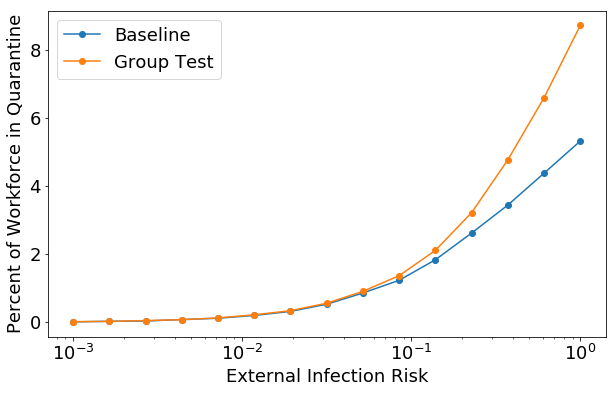

In [30]:
from statistics import mean
quarantine_mean_baseline = []
quarantine_mean_grptest = []

for trajectories_baseline, trajectories_grptest in zip(trajectory_collection_baselines, trajectory_collection_grptests):
    quarantine_mean_baseline.append(100 * mean([trajectory['mean_quarantine_pct'] for trajectory in trajectories_baseline]))
    quarantine_mean_grptest.append(100 * mean([trajectory['mean_quarantine_pct'] for trajectory in trajectories_grptest]))
    
plt.figure(figsize=(10,6))
plt.plot([100 * r for r in external_infection_risks], quarantine_mean_baseline, label="Baseline", marker='o')
plt.plot([100 * r for r in external_infection_risks], quarantine_mean_grptest, label="Group Test", marker='o')
plt.legend(loc='best')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("External Infection Risk")
plt.ylabel("Percent of Workforce in Quarantine")
plt.show()

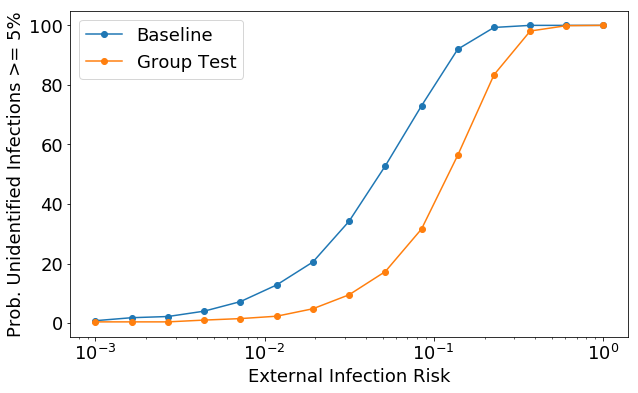

In [25]:
threshold = 0.05
baseline = []
grptest = []
for trajectories_baseline, trajectories_grptest in zip(trajectory_collection_baselines, trajectory_collection_grptests):
    baseline.append(100 * len([trajectory for trajectory in trajectories_baseline
                               if trajectory['max_infected_unquarantined_fraction'] >= threshold]) / 
                        len(trajectories_baseline))
    grptest.append(100 * len([trajectory for trajectory in trajectories_grptest
                               if trajectory['max_infected_unquarantined_fraction'] >= threshold]) / 
                        len(trajectories_grptest))
    
plt.figure(figsize=(10,6))
plt.plot([100 * r for r in external_infection_risks], baseline, label="Baseline", marker='o')
plt.plot([100 * r for r in external_infection_risks], grptest, label="Group Test", marker='o')
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel("External Infection Risk")
plt.ylabel("Prob. Unidentified Infections >= 5%")
#plt.yscale('log')
plt.show()

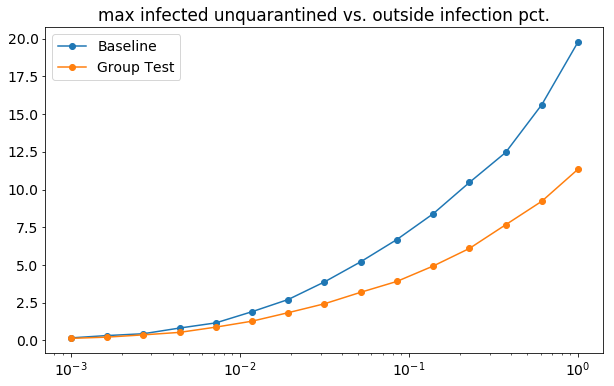

In [10]:
from statistics import mean
unquarantined_infection_baseline = []
unquarantined_infection_grptest = []

for trajectories_baseline, trajectories_grptest in zip(trajectory_collection_baselines, trajectory_collection_grptests):
    unquarantined_infection_baseline.append(100 * mean([trajectory['max_infected_unquarantined_fraction'] for trajectory in trajectories_baseline]))
    unquarantined_infection_grptest.append(100 * mean([trajectory['max_infected_unquarantined_fraction'] for trajectory in trajectories_grptest]))
    
plt.figure(figsize=(10,6))
plt.plot([100 * r for r in external_infection_risks], unquarantined_infection_baseline, label="Baseline", marker='o')
plt.plot([100 * r for r in external_infection_risks], unquarantined_infection_grptest, label="Group Test", marker='o')
plt.legend(loc='best')
plt.xscale('log')
#plt.yscale('log')
plt.title('max infected unquarantined vs. outside infection pct.')
plt.show()

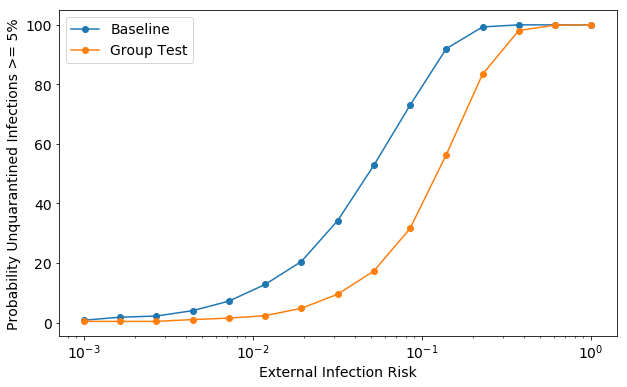

In [19]:
threshold = 0.05
baseline = []
grptest = []
for trajectories_baseline, trajectories_grptest in zip(trajectory_collection_baselines, trajectory_collection_grptests):
    baseline.append(100 * len([trajectory for trajectory in trajectories_baseline
                               if trajectory['max_infected_unquarantined_fraction'] >= threshold]) / 
                        len(trajectories_baseline))
    grptest.append(100 * len([trajectory for trajectory in trajectories_grptest
                               if trajectory['max_infected_unquarantined_fraction'] >= threshold]) / 
                        len(trajectories_grptest))
    
plt.figure(figsize=(10,6))
plt.plot([100 * r for r in external_infection_risks], baseline, label="Baseline", marker='o')
plt.plot([100 * r for r in external_infection_risks], grptest, label="Group Test", marker='o')
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel("External Infection Risk")
plt.ylabel("Probability Unquarantined Infections >= 5%")
#plt.yscale('log')
plt.show()

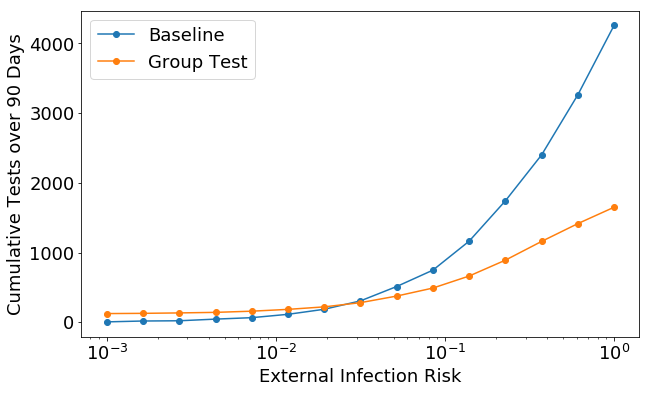

In [29]:
from statistics import mean
unquarantined_infection_baseline = []
unquarantined_infection_grptest = []

for trajectories_baseline, trajectories_grptest in zip(trajectory_collection_baselines, trajectory_collection_grptests):
    unquarantined_infection_baseline.append(mean([trajectory['cumulative_tests'] for trajectory in trajectories_baseline]))
    unquarantined_infection_grptest.append(mean([trajectory['cumulative_tests'] for trajectory in trajectories_grptest]))
    
plt.figure(figsize=(10,6))
plt.plot([100 * r for r in external_infection_risks], unquarantined_infection_baseline, label="Baseline", marker='o')
plt.plot([100 * r for r in external_infection_risks], unquarantined_infection_grptest, label="Group Test", marker='o')
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel("External Infection Risk")
plt.ylabel("Cumulative Tests over 90 Days")
#plt.yscale('log')
plt.show()

In [1]:
import numpy as np
np.linspace(-3,0,15)

array([-3.        , -2.78571429, -2.57142857, -2.35714286, -2.14285714,
       -1.92857143, -1.71428571, -1.5       , -1.28571429, -1.07142857,
       -0.85714286, -0.64285714, -0.42857143, -0.21428571,  0.        ])

In [ ]:
10**-3

In [12]:
list(range(1,10,2))

[1, 3, 5, 7, 9]

In [9]:
1e-03

0.001

In [71]:
range(1e-05, 0.001)

TypeError: 'float' object cannot be interpreted as an integer

In [80]:
xs = []
ys_baseline = []
ys_grptest = []
for x in trajectory_collection_baseline.keys():
    xs.append(0.0001 * x)
    ys_baseline.append(mean([trajectory['mean_quarantine_pct'] for trajectory in trajectory_collection_baseline[x]]))
    ys_grptest.append(mean([trajectory['mean_quarantine_pct'] for trajectory in trajectory_collection_grptest[x]]))

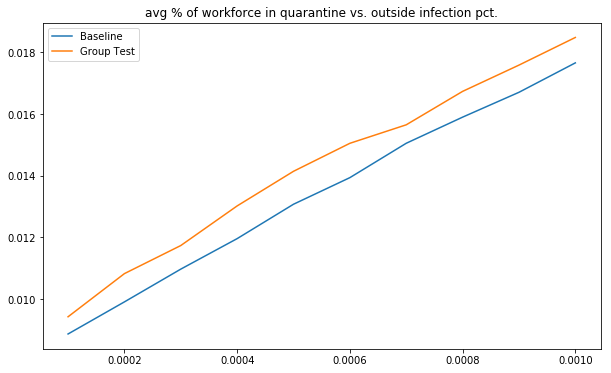

In [81]:
plt.figure(figsize=(10,6))
plt.plot(xs, ys_baseline, label="Baseline")
plt.plot(xs, ys_grptest, label="Group Test")

plt.legend(loc='best')
plt.title('avg % of workforce in quarantine vs. outside infection pct.')
plt.show()

In [76]:
xs = []
ys_baseline = []
ys_grptest = []
for x in trajectory_collection_baseline.keys():
    xs.append(0.0001 * x)
    ys_baseline.append(mean([trajectory['cumulative_infected_fraction'] for trajectory in trajectory_collection_baseline[x]]))
    ys_grptest.append(mean([trajectory['cumulative_infected_fraction'] for trajectory in trajectory_collection_grptest[x]]))

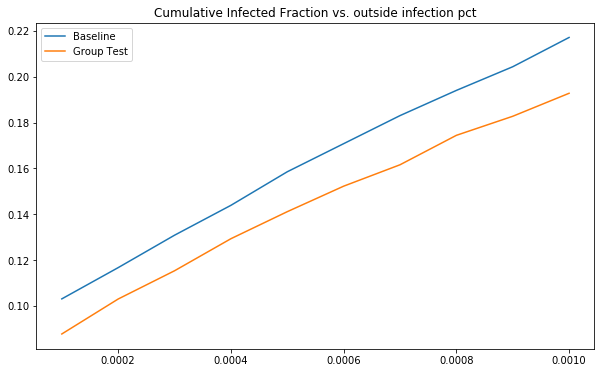

In [78]:
plt.figure(figsize=(10,6))
plt.plot(xs, ys_baseline, label="Baseline")
plt.plot(xs, ys_grptest, label="Group Test")

plt.legend(loc='best')
plt.title('Cumulative Infected Fraction vs. outside infection pct')
plt.show()

In [4]:
trajectories = collect_multiple_trajectories()

In [6]:
test_only_symptomatic_individuals = False
trajectories_grptest = collect_multiple_trajectories()

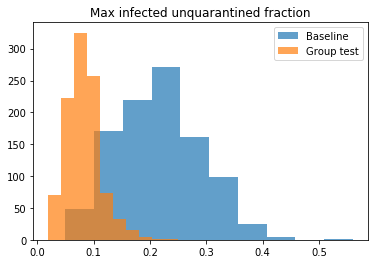

In [8]:
plt.hist([trajectory['max_infected_unquarantined_fraction'] for trajectory in trajectories], alpha=0.7, label="Baseline")
plt.hist([trajectory['max_infected_unquarantined_fraction'] for trajectory in trajectories_grptest], alpha=0.7, label="Group test")
plt.legend(loc='best')
plt.title('Max infected unquarantined fraction')
plt.show()

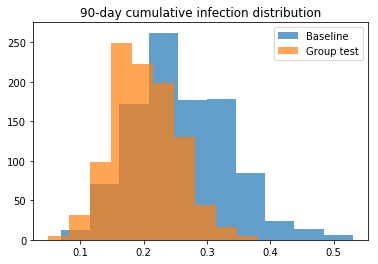

In [51]:
plt.hist([trajectory['cumulative_infected_fraction'] for trajectory in trajectories], alpha=0.7, label="Baseline")
plt.hist([trajectory['cumulative_infected_fraction'] for trajectory in trajectories_grptest], alpha=0.7, label="Group test")
plt.legend(loc='best')
plt.title('90-day cumulative infection distribution')
plt.show()

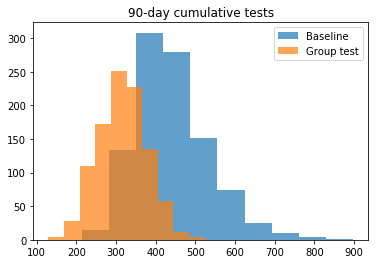

In [53]:
plt.hist([trajectory['cumulative_tests'] for trajectory in trajectories], alpha=0.7, label="Baseline")
plt.hist([trajectory['cumulative_tests'] for trajectory in trajectories_grptest], alpha=0.7, label="Group test")
plt.legend(loc='best')
plt.title('90-day cumulative tests')
plt.show()

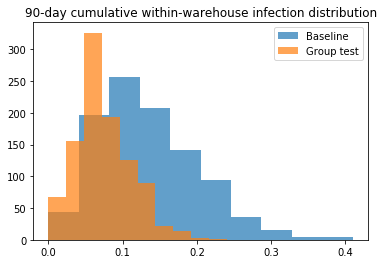

In [54]:
plt.hist([trajectory['cumulative_within_warehouse_fraction'] for trajectory in trajectories], alpha=0.7, label="Baseline")
plt.hist([trajectory['cumulative_within_warehouse_fraction'] for trajectory in trajectories_grptest], alpha=0.7, label="Group test")
plt.legend(loc='best')
plt.title('90-day cumulative within-warehouse infection distribution')
plt.show()

In [40]:
trajectories[0]

{'cumulative_days_halted': 60,
 'cumulative_infected_fraction': 0.38,
 'cumulative_infected_within_population': 0.21,
 'cumulative_tests_to_date': 569,
 'fatality_fraction': 0.0,
 'in_quarantine_fraction': 0.0,
 'infected_fraction': 0.04}

(array([ 51., 156., 248., 297., 121.,  74.,  39.,   8.,   3.,   3.]),
 array([0.   , 0.043, 0.086, 0.129, 0.172, 0.215, 0.258, 0.301, 0.344,
        0.387, 0.43 ]),
 <a list of 10 Patch objects>)

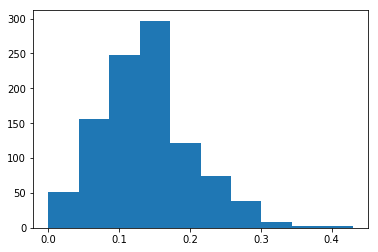

In [39]:
plt.hist([trajectory['cumulative_infected_within_population'] for trajectory in trajectories])

(array([ 21.,  29.,  62., 121., 181., 190., 181., 131.,  58.,  26.]),
 array([15. , 20.3, 25.6, 30.9, 36.2, 41.5, 46.8, 52.1, 57.4, 62.7, 68. ]),
 <a list of 10 Patch objects>)

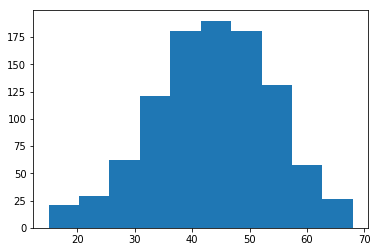

In [41]:
plt.hist([trajectory['cumulative_days_halted'] for trajectory in trajectories])

Total number of tests performed over 90 days: 358


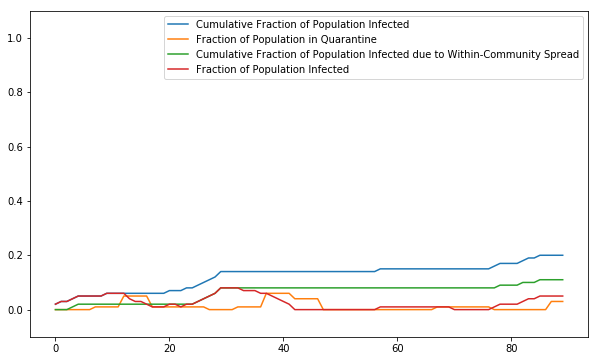

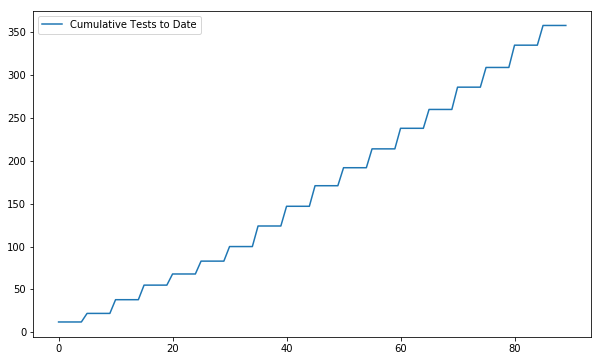

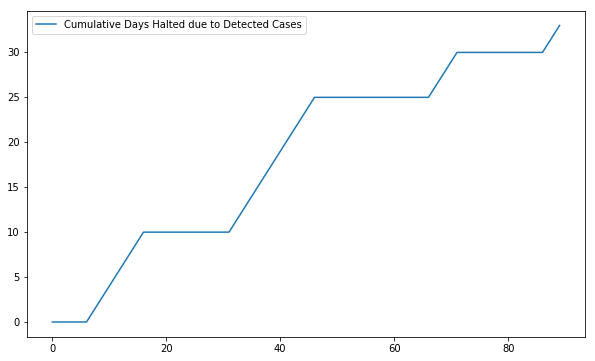

In [31]:
simulation = initiate_simulation()
run(simulation, number_of_days=90)
summarize(simulation)

In [19]:
test_only_symptomatic_individuals = False

Total number of tests performed over 60 days: 195


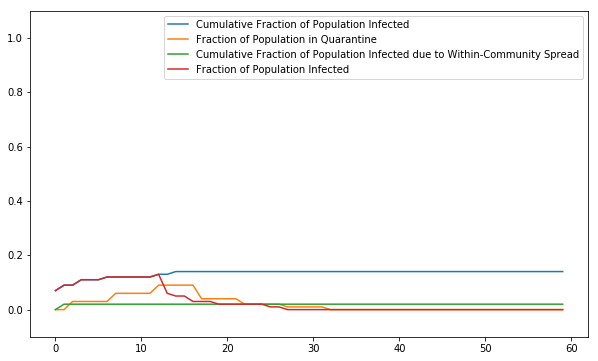

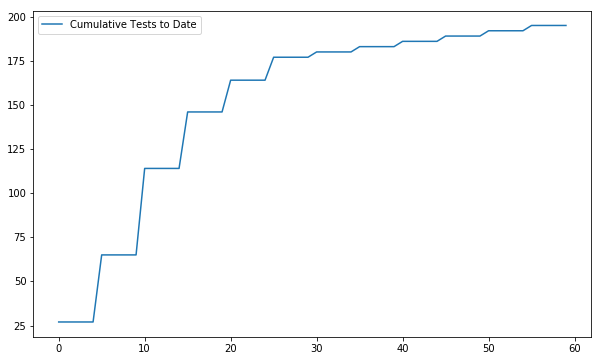

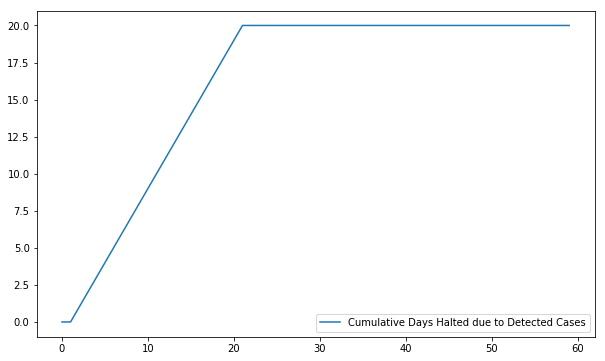

In [27]:
simulation = initiate_simulation()
run(simulation, number_of_days=60)
summarize(simulation)

In [ ]:
j